# Logistic regression Assumptions

- log-odds linearity
- multicollinearity
- outliers


## Data Loading


In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import json

from python_proj.utils.util import safe_save_fig, subtract_dict, Counter
import python_proj.utils.exp_utils as exp_utils

file_name = "dataset_90_days_started_11_07_23_preprocessed"
base_path = exp_utils.BASE_PATH
data_path = f'{base_path}/final_data/{file_name}.csv'
figure_base_path = f"{base_path}/figures/modelling/{file_name}/"

# Meta stuff.
pr_merged_key = 'PullRequestIsMerged'
ftc_key = 'SubmitterIsFirstTimeContributor'
seed_counter = Counter()


# Loads regular dataframe.
df: pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)
if 'Unnamed: 1' in df.columns:
    df = df.drop(['Unnamed: 1', "Project Name.1"], axis=1)
print(df.columns)

# Loads first-time contributor data frame.
ftc_df = df[df[ftc_key]]
print(f'{len(df)=}')
print(f'{len(ftc_df)=}')

# Creates sub-datasets.
metadata_fields = ['ID', 'Project Name',
                   'Submitter ID', 'PR Number', 'Closed At']
dependent_fields = [pr_merged_key]
independent_fields = [field for field in df.columns
                      if (field not in metadata_fields
                          and field not in dependent_fields)]

# Removes fields with only columns from ftc dataset.
ftc_columns_old = ftc_df.columns
ftc_df = ftc_df.loc[:, (ftc_df != 0).any()]
ftc_columns_new = ftc_df.columns
ftc_removed = [field for field in ftc_columns_old
               if field not in ftc_columns_new]
print(f'{ftc_removed=}')

df[independent_fields].describe()


Index(['Project Name', 'Closed At', 'PullRequestIsMerged',
       'ControlIntegratedBySameUser', 'ControlPullRequestLifeTimeInMinutes',
       'ControlPullRequestHasComments', 'ControlNumberOfCommitsInPullRequest',
       'ControlHasHashTagInDescription',
       'ControlIntraProjectPullRequestExperienceOfIntegrator',
       'IntraProjectSubmitterPullRequestSubmissionCount',
       'IntraProjectSubmitterPullRequestSuccessRate',
       'IntraProjectSubmitterPullRequestCommentCount',
       'SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator',
       'SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter',
       'SharedExperiencePullRequestSubmittedBySubmitterCommentedOnByIntegrator',
       'SharedExperiencePullRequestSubmittedByIntegratorCommentedOnBySubmitter',
       'SharedExperiencePullRequestDiscussionParticipationByIntegratorAndSubmitter',
       'EcosystemExperienceSubmitterPullRequestSuccessRate',
       'EcosystemExperienceSubmitterPullReques

,ControlPullRequestLifeTimeInMinutes,ControlNumberOfCommitsInPullRequest,ControlIntraProjectPullRequestExperienceOfIntegrator,IntraProjectSubmitterPullRequestSubmissionCount,IntraProjectSubmitterPullRequestSuccessRate,IntraProjectSubmitterPullRequestCommentCount,SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator,SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter,SharedExperiencePullRequestSubmittedBySubmitterCommentedOnByIntegrator,SharedExperiencePullRequestSubmittedByIntegratorCommentedOnBySubmitter,...,EcosystemExperienceSubmitterIssueCommentCount,DependencyEcosystemExperienceSubmitterIssueSubmissionCount,DependencyEcosystemExperienceSubmitterIssueCommentCount,InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount,InversedDependencyEcosystemExperienceSubmitterIssueCommentCount,WeightedFirstOrderInDegreeCentrality,WeightedFirstOrderOutDegreeCentrality,ln(1 + ID),ln(1 + Submitter ID),ln(1 + PR Number)
count,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,...,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06
mean,8.195118e-03,4.261849e-04,9.423142e-03,5.824308e-03,5.030041e-01,6.019321e-03,5.777940e-03,1.173644e-03,4.367466e-03,5.316719e-04,...,2.645724e-03,5.434402e-04,9.320177e-04,3.472994e-04,6.502745e-04,4.581919e-05,3.013253e-05,9.002245e-01,7.825601e-01,4.250153e-01
std,3.428228e-02,5.654810e-03,2.743843e-02,2.044922e-02,4.710844e-01,1.929760e-02,2.653875e-02,1.194221e-02,1.992043e-02,5.180242e-03,...,9.296030e-03,4.591067e-03,1.015639e-02,3.932471e-03,6.829193e-03,1.500140e-03,1.278784e-03,9.013367e-02,1.145916e-01,1.718811e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.208060e-06,1.000000e-04,7.022472e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.626972e-01,7.179702e-01,3.045825e-01
50%,1.987457e-04,1.000000e-04,2.574906e-03,5.882353e-04,6.818182e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.310616e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.080745e-06,4.405803e-07,9.262134e-01,7.907818e-01,4.330947e-01
75%,1.773738e-03,3.000000e-04,8.895131e-03,5.294118e-03,1.000000e+00,4.117647e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.179554e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.440783e-06,2.621605e-06,9.643572e-01,8.687982e-01,5.490112e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


## Log-odds linearity


### Visual checking


untransformed
ControlPullRequestLifeTimeInMinutes:
0.00    3.712374e-09
0.25    8.211772e-06
0.50    1.987605e-04
0.75    1.773839e-03
1.00    1.000000e+00
Name: ControlPullRequestLifeTimeInMinutes, dtype: float64

x=[1.366153782095398e-06, 4.0754446249574114e-05, 0.0005479910110942, 0.0085340619744229], y=[1.9010607025110347, 1.9027961295172873, 1.6075537395121242, 0.30752687081421703]
ControlNumberOfCommitsInPullRequest:
0.00    0.0001
0.25    0.0001
0.50    0.0001
0.75    0.0003
1.00    1.0000
Name: ControlNumberOfCommitsInPullRequest, dtype: float64

x=[0.0001, 0.0001, 0.0001, 0.0005], y=[1.278404656898358, 1.278404656898358, 1.3149627541929216, 1.3471131728771892]
ControlIntraProjectPullRequestExperienceOfIntegrator:
0.00    0.000234
0.25    0.000936
0.50    0.003277
0.75    0.010066
1.00    1.000000
Name: ControlIntraProjectPullRequestExperienceOfIntegrator, dtype: float64

x=[0.0004681647940074, 0.0016385767790262, 0.0056179775280898, 0.0203651685393258], y=[0.8413531581715882,

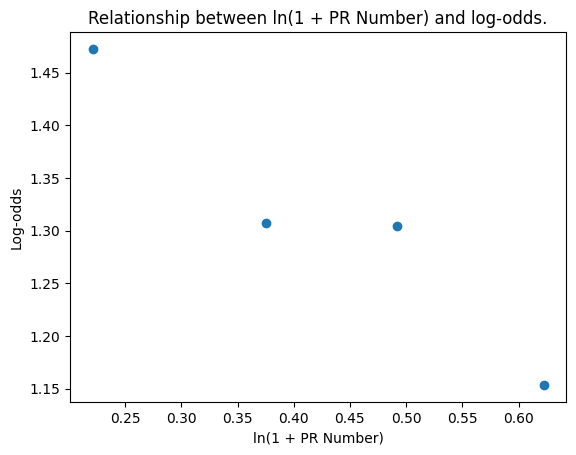

In [2]:
import regex as re
from numbers import Number
from typing import Callable, Iterator
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from python_proj.utils.util import tuple_chain, lies_between


def test_log_linearity(
    independents: pd.DataFrame,
    dependent: pd.Series,
    transform_title: str = ""
):
    continuous_fields = independents.select_dtypes(include='number')

    all_data = pd.DataFrame()
    all_data[continuous_fields.columns] = continuous_fields.copy()
    all_data[pr_merged_key] = dependent.copy()


    for field in continuous_fields.columns:
        # Creates copy of the relevant fields.
        included = pd.DataFrame()
        included[field] = all_data[field].copy()
        included[pr_merged_key] = all_data[pr_merged_key].copy()

        # Removes data that will signifcantly skew the results.
        if re.match(r'.*SuccessRate.*', field):
            # TODO: Figure out what to do with success rate.
            # We can't properly test the log-linearity with the current data.
            count_field = field[:-len('SuccessRate')] + "SubmissionCount"
            included[count_field] = all_data[count_field].copy()
            included = included[included[count_field] > 0]
            perc_quantiles = [0, 0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 0.9, 1]
        else:
            included = included[included[field] > 0]
            perc_quantiles = [0, 0.25, 0.5, 0.75, 1]

        # Calculates quantiles.
        quantiles = included[field].quantile(perc_quantiles)
        print(f'{field}:')
        print(quantiles)
        print()

        x = []
        y = []
        skip_flag = False
        for r_start, r_end in tuple_chain(list(quantiles)):
            quant_data: pd.DataFrame = included[(
                included[field] >= r_start) & (included[field] <= r_end)]
            # quant_mean = quant_data[field].mean()
            quant_mean = quant_data[field].median()
            merged_entries = quant_data[quant_data[pr_merged_key] == True]
            probability = len(merged_entries) / len(quant_data)
            if probability == 1:
                skip_flag = True
                break
            log_odds = np.log(probability / (1 - probability))
            x.append(quant_mean)
            y.append(log_odds)

        if skip_flag:
            print(f'Skipped {field} because of division by zero.')
            continue

        print(f'{x=}, {y=}')

        plt.clf()
        plt.scatter(x, y)
        plt.title(f"Relationship between {field} and log-odds.")
        plt.xlabel(field)
        plt.ylabel("Log-odds")

        output_path = f'{figure_base_path}/log-odds-independence/{transform_title}/{field}'
        safe_save_fig(output_path)


def test_log_linearity_with_transforms(
    transforms: Iterator[Callable[[Number], Number]],
    independents: pd.DataFrame,
    dependent: pd.Series,
    figure_subfolder: str,
):
    continuous_fields = independents.select_dtypes(include='number')
    for transform in transforms:
        print(f"\n{transform.__name__}")
        transformed_independents = continuous_fields.copy()
        for field in transformed_independents.columns:
            transformed_independents[field] = transformed_independents[field]\
                .apply(transform)
            mn = transformed_independents[field].min()
            mx = transformed_independents[field].max()
            transformed_independents[field] = transformed_independents[field]\
                .apply(lambda x: (x - mn) / (mx - mn))
        test_log_linearity(transformed_independents,
                           dependent, f'{figure_subfolder}/{transform.__name__}')


def untransformed(value):
    return value


def ln_transform(value):
    return np.log(1 + value)


def sqrt_transform(value):
    return np.sqrt(1 + value)


def cbrt_transform(value):
    return np.cbrt(1 + value)


def reciprocal_transform(value):
    return 1 / (1 + value)


def squared_transform(value):
    return value ** 2


def ln_ln_transform(value):
    return np.log(1 + np.log(1 + value))


def ln_eps_transform(value):
    return np.log(0.1 + value)


def ln_eps_e2_transform(value):
    return np.log(0.01 + value)


def ln_eps_e3_transform(value):
    return np.log(0.001 + value)


def cubed_transform(value):
    return value ** 3


def ln_complement(value):
    return np.log(1.0 + (1.0 - value))


def ln_eps_complement(value):
    return np.log(0.001 + (1.0 - value))


def ln_eps_e5_complement(value):
    return np.log(0.00001 + (1.0 - value))


def compl_squared_compl(value):
    return 1.0 - ((1.0 - value) ** 2)


transforms = [
    untransformed,
    # ln_transform,
    # sqrt_transform,
    # cbrt_transform,
    # reciprocal_transform,
    # ln_complement,
    # ln_eps_complement,
    # compl_squared_compl,
    # squared_transform,
    # cubed_transform,
    # ln_ln_transform,
    # ln_eps_e2_transform,
    # ln_eps_e3_transform,
    # ln_eps_e5_complement
]


# Full model.
independents = df[independent_fields]
dependent = df[pr_merged_key]
test_log_linearity_with_transforms(
    transforms, independents, dependent, "full_model")

# # First-time contributor model.
# ftc_data = df[df['SubmitterIsFirstTimeContributor'] == True]
# independents = ftc_data[independent_fields]
# dependent = ftc_data[pr_merged_key]
# test_log_linearity_with_transforms(
#     transforms, independents, dependent, "ftc_model")

# Dependency model
# dependency_re = r'.*Dependency.*$'
# dependency_fields = [field for field in df.columns if re.match(dependency_re, field)]
# dependency_data = df[df[dependency_fields].any(axis=1)]
# independents = dependency_data[independent_fields]
# dependent = dependency_data[pr_merged_key]
# test_log_linearity_with_transforms(
#     transforms, independents, dependent, "dep_model")


## Box-Tidwill Test

In [3]:
def box_tidwill_test(
    independents: pd.DataFrame(),
    dependent: pd.Series()
):
    continuous_fields = independents.select_dtype(include='number')

    ln_field = f'ln(x) * x'
    for field in continuous_fields:
        test_independents = independents[[field]].copy()
        # TODO: Can you do this?! the ``1 + x`` thing?
        test_independents[ln_field] = test_independents[field]\
            .apply(lambda x: np.ln(0.0001 + x) * (0.0001 + + x))
        test_independents = sm.add_constant(test_independents)

        logit_model = sm.Logit(dependent,
                               test_independents).fit()

        p_value = logit_model.pvalues[ln_field]
        is_significant = p_value < 0.05

        test_result = "failed" if is_significant else "passed"
        print(f'{field} {test_result} with {p_value=:.05f}.')


independents = df[independent_fields]
dependent = df[pr_merged_key]
box_tidwill_test(independents, dependent)


AttributeError: 'DataFrame' object has no attribute 'select_dtype'

## Multicolinearity


In [ ]:
multicollinear_fields = [
    # ### Cluster: if it has comments, it will commonly have a comment from an external user as well?
    # 'ControlPullRequestHasCommentByExternalUser',
    "ControlPullRequestHasComments",


    # Almost all of the shared experience fields correlate directly with each other.
    # 3/7 correlate with everything, 2 with everything - 1, and 2 with fewer than that.
    # They discussed stuff in issues correlates with: pull requests submitted
    # and commenting/disc. participation (in either direction) on PRs and issues;
    # i.e., if people cooperate, they cooperate across the board.


    # ### Cluster: Shared experience; i.e., people work together.
    # "ln(1 + SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator)",
    "ln(1 + SharedExperiencePullRequestSubmittedBySubmitterCommentedOnByIntegrator)",
    # "ln(1 + SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter)",
    "ln(1 + SharedExperiencePullRequestSubmittedByIntegratorCommentedOnBySubmitter)",
    "ln(1 + SharedExperiencePullRequestDiscussionParticipationByIntegratorAndSubmitter)",
    "ln(1 + SharedExperienceIssueSubmittedByIntegratorCommentedOnBySubmitter)",
    "ln(1 + SharedExperienceIssueSubmittedBySubmitterCommentedOnByIntegrator)",
    "ln(1 + SharedExperienceIssueDiscussionParticipationByIntegratorAndSubmitter)",



    # ### Cluster: Inversed dependencies - pulls and issues.
    # All of their coeficients are positive, so more pulls = more acceptance =
    # more issues = more comments in the ecosystem.
    # All of them correlate with the others, so we can keep only 1.
    # "ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)", # corr with 4
    "InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate",
    "ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)",
    "ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount)",
    "ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount)",

    # ### Cluster: Not a cluster, but these two form a bridge between two clusters.
    # This relation makes complete sense as if you submit PRs in the dependency ecosystem,
    # you submit them in the general ecosystem too. There's no reason to pick either, however,
    # Ecosystem exp has more data to it.
    "ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)",
    "ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)",

    # ### CLuster: In the ecosystem, commenting on issues and PRs correlates with
    # Issue submission counts and PR success rate.
    # "ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)",
    "ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)",
    "ln(1 + EcosystemExperienceSubmitterIssueCommentCount)",
    # "EcosystemExperienceSubmitterPullRequestSuccessRate",

    # ### Cluster: Dependency ecosystem experience.
    # All of these are positively correlated; i.e., if you do more you do more and better.
    # corr. with 3 (PR sub, PR com, Issue comm)
    "DependencyEcosystemExperienceSubmitterPullRequestSuccessRate",
    # corr. with 4
    "ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)",
    # corr. with 4
    "ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)",
    # "ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount)", # corr. with 3
    "ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount)",  # corr with 4

    # ### Cluster Pr Success rate correlates with FTC (which I didn't want to include like this anyways),
    # and the more PR submissions you do and more PR comments you give, the worse you perform.
    # "IntraProjectSubmitterPullRequestSuccessRate",
    "SubmitterIsFirstTimeContributor",
    "ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)",
    "ln(1 + IntraProjectSubmitterPullRequestCommentCount)",
    # "ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)",
    "ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)",
    "ln(1 + IntraProjectSubmitterIssueSubmissionCount)",

]

multicollinear_fields = [
    # ### Cluster: In/out weighted degree.
    # "sqrt(1 + WeightedFirstOrderInDegreeCentrality)",
    "sqrt(1 + WeightedFirstOrderOutDegreeCentrality)",

    # ### Cluster: Inversed dependency experience.
    # "recip(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)",
    "recip(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)",
    "recip(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount)",
    "recip(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount)",
    "InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate^2",

    # ### CLuster: ecosystem experience.
    # "recip(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)",
    "recip(1 + EcosystemExperienceSubmitterPullRequestCommentCount)",
    "recip(1 + EcosystemExperienceSubmitterIssueSubmissionCount)",
    "recip(1 + EcosystemExperienceSubmitterIssueCommentCount)",
    "EcosystemExperienceSubmitterPullRequestSuccessRate^2",

    # ### Cluster: Intra-project experience.
    # "SubmitterIsFirstTimeContributor",
    "recip(1 + IntraProjectSubmitterPullRequestSubmissionCount)",
    # "recip(1 + IntraProjectSubmitterPullRequestCommentCount)",
    # "recip(1 + IntraProjectSubmitterIssueSubmissionCount)",
    # "recip(1 + IntraProjectSubmitterIssueCommentCount)",
    # "IntraProjectSubmitterPullRequestSuccessRate^2"

    # TODO: Continue here.
]

print(f'{len(multicollinear_fields)=}')


len(multicollinear_fields)=0


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def change_bin_fields_to_float(__df: pd.DataFrame):
    repl_df = __df.copy()
    value_mapper = {False: 0, True: 1}
    
    binary_fields = __df.select_dtypes(exclude='number')
    for feature in binary_fields:
        repl_df[feature] = __df[feature].replace(value_mapper)

    return repl_df

tested_predictors = df[independent_fields].drop(multicollinear_fields, axis=1)
tested_predictors = change_bin_fields_to_float(tested_predictors)

vif_df = pd.DataFrame()
vif_df['variable'] = tested_predictors.columns
vif_df['VIF'] = [variance_inflation_factor(tested_predictors.values, i)
                 for i in range(tested_predictors.shape[1])]

print(vif_df)

                                             variable         VIF
0                         ControlIntegratedBySameUser    4.516935
1                       ControlPullRequestHasComments    3.919967
2                      ControlHasHashTagInDescription    1.585839
3                     SubmitterIsFirstTimeContributor    5.437451
4          ControlPullRequestHasCommentByExternalUser    1.778596
5   ln(1 + SharedExperienceIssueSubmittedByIntegra...    1.620400
6   recip(1 + IntraProjectSubmitterPullRequestSubm...   20.364712
7   recip(1 + IntraProjectSubmitterPullRequestComm...   11.158617
8   recip(1 + SharedExperiencePullRequestSubmitted...   47.712172
9   recip(1 + SharedExperiencePullRequestSubmitted...   86.685718
10  recip(1 + SharedExperiencePullRequestSubmitted...   65.039412
11  recip(1 + SharedExperiencePullRequestSubmitted...   67.839563
12  recip(1 + SharedExperiencePullRequestDiscussio...   41.169321
13  recip(1 + EcosystemExperienceSubmitterPullRequ...   20.666657
14  recip(

In [ ]:
problematic_vif = vif_df[vif_df['VIF'] >= 5]
print("Problematic VIF scores:")
print(problematic_vif)

Problematic VIF scores:
                                             variable         VIF
3                     SubmitterIsFirstTimeContributor    5.437451
6   recip(1 + IntraProjectSubmitterPullRequestSubm...   20.364712
7   recip(1 + IntraProjectSubmitterPullRequestComm...   11.158617
8   recip(1 + SharedExperiencePullRequestSubmitted...   47.712172
9   recip(1 + SharedExperiencePullRequestSubmitted...   86.685718
10  recip(1 + SharedExperiencePullRequestSubmitted...   65.039412
11  recip(1 + SharedExperiencePullRequestSubmitted...   67.839563
12  recip(1 + SharedExperiencePullRequestDiscussio...   41.169321
13  recip(1 + EcosystemExperienceSubmitterPullRequ...   20.666657
14  recip(1 + EcosystemExperienceSubmitterPullRequ...   12.996365
15  recip(1 + DependencyEcosystemExperienceSubmitt...  143.612753
16  recip(1 + DependencyEcosystemExperienceSubmitt...   60.424856
17  recip(1 + InversedDependencyEcosystemExperienc...  237.766698
18  recip(1 + InversedDependencyEcosystemExperienc..

coof_threshold=0.5
Correlating pairs:
[
    [
        "recip(1 + IntraProjectSubmitterPullRequestSubmissionCount)",
        "SubmitterIsFirstTimeContributor",
        0.8291909689652015
    ],
    [
        "recip(1 + IntraProjectSubmitterPullRequestCommentCount)",
        "SubmitterIsFirstTimeContributor",
        0.631222302018068
    ],
    [
        "recip(1 + SharedExperienceIssueDiscussionParticipationByIntegratorAndSubmitter)",
        "ln(1 + SharedExperienceIssueSubmittedByIntegratorCommentedOnBySubmitter)",
        -0.5488455894766353
    ],
    [
        "recip(1 + IntraProjectSubmitterPullRequestSubmissionCount)",
        "recip(1 + IntraProjectSubmitterPullRequestCommentCount)",
        0.750292782670107
    ],
    [
        "recip(1 + SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator)",
        "recip(1 + SharedExperiencePullRequestSubmittedBySubmitterCommentedOnByIntegrator)",
        0.8723953640072799
    ],
    [
        "recip(1 + SharedExperience

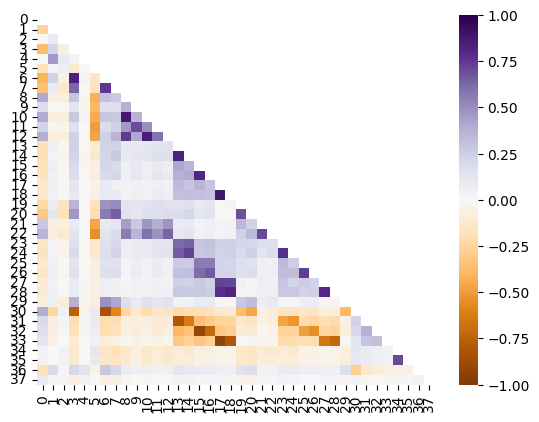

In [ ]:
import seaborn as sb
import json
from python_proj.utils.util import SafeDict

tick_labels = list(range(len(vif_df)))
corr = tested_predictors.corr()

rows, cols = corr.shape
mask = np.invert(np.tril(np.ones((rows, cols), dtype=bool), k=-1))
dataplot = sb.heatmap(corr, cmap="PuOr",
                      xticklabels=tick_labels, yticklabels=tick_labels,
                      mask=mask,
                      vmin=-1, vmax=1)


def get_correlating_fields(coof_threshold, corr):
    print(f'{coof_threshold=}')
    correlating_fields = []
    # print(corr)
    for rowIndex, row in corr.iterrows():  # iterate over rows
        for columnIndex, coof in row.items():
            if columnIndex <= rowIndex:
                continue
            if abs(coof) < coof_threshold:
                continue
            correlating_fields.append([columnIndex, rowIndex, coof])
    correlating_fields = [list(entry) for entry in correlating_fields]
    print("Correlating pairs:\n" + json.dumps(correlating_fields, indent=4) + "\n")
    return correlating_fields


correlating_fields = get_correlating_fields(coof_threshold=0.5, corr=corr)

# Identify problematic fields:
presence_counts = SafeDict(default_value=0)
for (field_a, field_b, _) in correlating_fields:
    presence_counts[field_a] += 1
    presence_counts[field_b] += 1
pc = list(presence_counts.items())
pc.sort(key=lambda x: x[1])
print(f'Variable correlation frequency:\n{json.dumps(pc, indent=4)}\n')

# Generate transitive closures


def unify_if_overlapping(collections: list[list]):
    # gather the lists that do overlap
    overlapping = [x for x in collections if
                   any(x_element in [y for k in collections
                                     if k != x for y in k]
                       for x_element in x)]
    # flatten and get unique
    overlapping = sorted(list(set([z for x in overlapping for z in x])))
    # get the rest
    non_overlapping = [x for x in collections if all(
        y not in overlapping for y in x)]
    # use the line bellow only if merged non-overlapping elements are desired
    # non_overlapping = sorted([y for x in non_overlapping for y in x])
    non_overlapping.append(overlapping)
    return non_overlapping


correlating_no_coof = [(a, b) for (a, b, _) in correlating_fields]
unified = unify_if_overlapping(correlating_no_coof)
print("Transitive closure of correlating pairs:\n" +
      json.dumps(unified, indent=4))


Plots a graph when there are correlating fields.


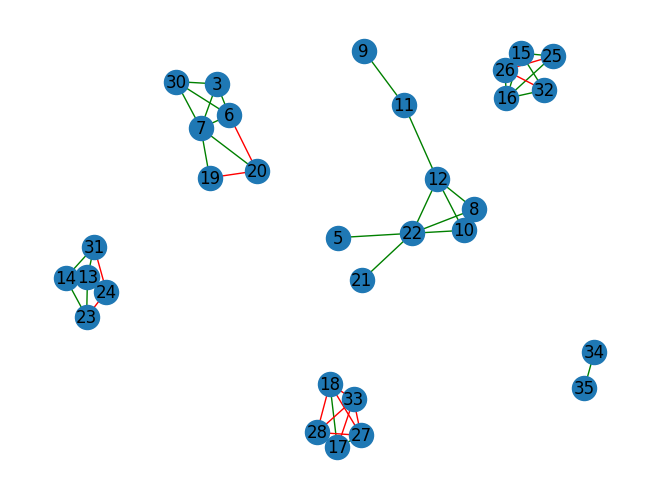

[[0, "ControlIntegratedBySameUser"], [1, "ControlPullRequestHasComments"], [2, "ControlHasHashTagInDescription"], [3, "SubmitterIsFirstTimeContributor"], [4, "ControlPullRequestHasCommentByExternalUser"], [5, "ln(1 + SharedExperienceIssueSubmittedByIntegratorCommentedOnBySubmitter)"], [6, "recip(1 + IntraProjectSubmitterPullRequestSubmissionCount)"], [7, "recip(1 + IntraProjectSubmitterPullRequestCommentCount)"], [8, "recip(1 + SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator)"], [9, "recip(1 + SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter)"], [10, "recip(1 + SharedExperiencePullRequestSubmittedBySubmitterCommentedOnByIntegrator)"], [11, "recip(1 + SharedExperiencePullRequestSubmittedByIntegratorCommentedOnBySubmitter)"], [12, "recip(1 + SharedExperiencePullRequestDiscussionParticipationByIntegratorAndSubmitter)"], [13, "recip(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)"], [14, "recip(1 + EcosystemExperienceSubmitterPullReque

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

if len(correlating_fields) > 0:
    fields = list(tested_predictors.columns)
    enumerated_list = list(enumerate(fields))
    ids = []
    edge_colors = []
    for source, target, coof in correlating_fields:
        source_idx = fields.index(source)
        target_idx = fields.index(target)
        ids.append((source_idx, target_idx))
        edge_colors.append('red' if coof < 0 else 'green')

    # Create an empty graph
    graph = nx.Graph()    


    # Add edges to the graph from the list of tuples
    graph.add_edges_from(ids)

    pos = nx.spring_layout(graph, k=0.4)
    nx.draw(graph, pos, with_labels=True, edge_color=edge_colors)
    plt.show()

    print(json.dumps(enumerated_list))


In [ ]:
print(f'{len(tested_predictors.columns)=}')
print(f'{tested_predictors.columns=}')

len(tested_predictors.columns)=38
tested_predictors.columns=Index(['ControlIntegratedBySameUser', 'ControlPullRequestHasComments',
       'ControlHasHashTagInDescription', 'SubmitterIsFirstTimeContributor',
       'ControlPullRequestHasCommentByExternalUser',
       'ln(1 + SharedExperienceIssueSubmittedByIntegratorCommentedOnBySubmitter)',
       'recip(1 + IntraProjectSubmitterPullRequestSubmissionCount)',
       'recip(1 + IntraProjectSubmitterPullRequestCommentCount)',
       'recip(1 + SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator)',
       'recip(1 + SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter)',
       'recip(1 + SharedExperiencePullRequestSubmittedBySubmitterCommentedOnByIntegrator)',
       'recip(1 + SharedExperiencePullRequestSubmittedByIntegratorCommentedOnBySubmitter)',
       'recip(1 + SharedExperiencePullRequestDiscussionParticipationByIntegratorAndSubmitter)',
       'recip(1 + EcosystemExperienceSubmitterPullRequestSub

## Outliers
